# Importing Libraries

In [54]:
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, f1_score
import time
import pickle 
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Reading Files

In [55]:
crude_oil_prices = pd.read_csv('../InputData/crude_oil_prices.csv')
federal_rates = pd.read_csv('../InputData/effective_federal_funds_rate.csv')
corridor_rates = pd.read_csv('../InputData/egyptian_corridor_interest_rates.csv')
housing_index = pd.read_csv('../InputData/housing_index.csv')
inflation_mom = pd.read_csv('../InputData/inflation_month_on_month.csv')
inflation_yoy = pd.read_csv('../InputData/inflation_year_on_year.csv')
news_data = pd.read_csv('../InputData/news.csv')
stock_prices = pd.read_csv('../InputData/stocks_prices_and_volumes.csv')
vix_indices = pd.read_csv('../InputData/vix_index.csv')
vixeem_indices = pd.read_csv('../InputData/vxeem_index.csv')
gold_prices = pd.read_csv('../InputData/intraday_gold.csv')
gold_prices_target = pd.read_csv('../InputData/target_gold.csv')

In [56]:
gold_prices_target.head()

,date,pct_change
0,2020-01-01,0.129032
1,2020-01-02,1.288660
2,2020-01-03,0.636132
3,2020-01-04,0.126422
4,2020-01-05,1.262626


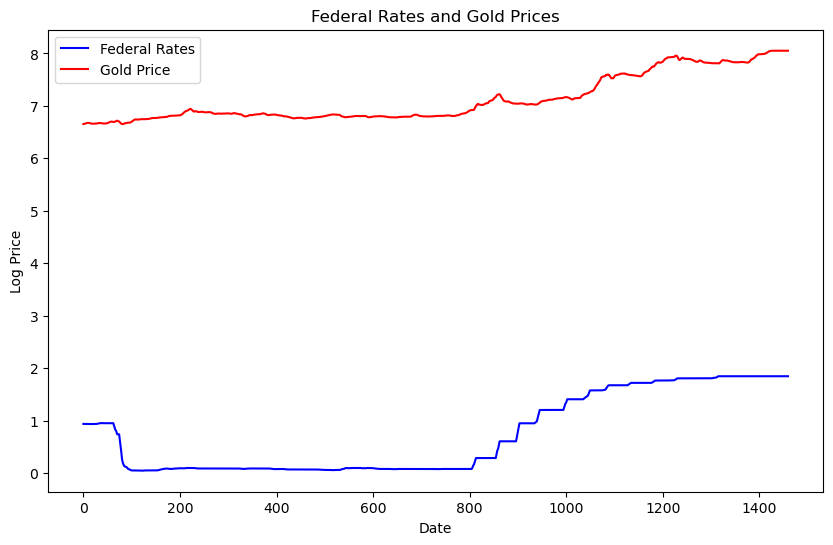

In [57]:
merged_data_list_federal_gold = []

# Convert 'Date' columns to date object
federal_rates['Date'] = pd.to_datetime(federal_rates['Date']).dt.date
gold_prices['Timestamp'] = pd.to_datetime(gold_prices['Timestamp'], errors='coerce', utc=True)
gold_prices['Date'] = gold_prices['Timestamp'].dt.date

# Get daily gold prices
gold_daily = gold_prices.groupby('Date').last().reset_index()

for federal_rates_column in federal_rates.columns:
    if federal_rates_column == 'Date':
        continue

    # Get start and end dates relative to each dataset
    start_date = max(federal_rates['Date'].min(), gold_daily['Date'].min())
    end_date = min(federal_rates['Date'].max(), gold_daily['Date'].max())

    # Filter the data based on start and end date
    federal_rates_filtered = federal_rates[(federal_rates['Date'] >= start_date) & (federal_rates['Date'] <= end_date)]
    gold_daily_filtered = gold_daily[(gold_daily['Date'] >= start_date) & (gold_daily['Date'] <= end_date)]

    # Merge the two datasets on 'Date'
    merged_data = pd.merge(federal_rates_filtered, gold_daily_filtered, on='Date', how='inner')

    # Ensure the columns are numeric
    merged_data[federal_rates_column] = pd.to_numeric(merged_data[federal_rates_column], errors='coerce')
    merged_data['24K'] = pd.to_numeric(merged_data['24K'], errors='coerce')

    # Apply interpolation only to numeric columns
    numeric_cols = merged_data.select_dtypes(include=['float64', 'int64']).columns
    merged_data[numeric_cols] = merged_data[numeric_cols].interpolate(method='linear', limit_direction='both')

    # Create Log Columns
    merged_data['log_federal_rates'] = np.log(merged_data[federal_rates_column] + 1)
    merged_data['Log_Gold_Price'] = np.log(merged_data['24K'] + 1)

    # Calculate the mean and standard deviation for both series
    mean_gold_price = merged_data['Log_Gold_Price'].mean()
    std_gold_price = merged_data['Log_Gold_Price'].std()
    mean_stock_price = merged_data['log_federal_rates'].mean()
    std_stock_price = merged_data['log_federal_rates'].std()

    # Calculate thresholds for outliers
    threshold_upper_gold = mean_gold_price + 2 * std_gold_price
    threshold_lower_gold = mean_gold_price - 2 * std_gold_price
    threshold_upper_stock = mean_stock_price + 2 * std_stock_price
    threshold_lower_stock = mean_stock_price - 2 * std_stock_price

    # Remove duplicate dates
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    merged_data = merged_data.drop_duplicates(subset='Date')

    # Mask outliers
    outlier_mask_gold = (merged_data['Log_Gold_Price'] < threshold_lower_gold) | (merged_data['Log_Gold_Price'] > threshold_upper_gold)
    outlier_mask_stock = (merged_data['log_federal_rates'] < threshold_lower_stock) | (merged_data['log_federal_rates'] > threshold_upper_stock)

    # Set outliers to NaN
    merged_data.loc[outlier_mask_gold, 'Log_Gold_Price'] = np.nan
    merged_data.loc[outlier_mask_stock, 'log_federal_rates'] = np.nan

    # Interpolate missing values for log columns
    merged_data['Log_Gold_Price'] = merged_data['Log_Gold_Price'].interpolate(method='linear')
    merged_data['log_federal_rates'] = merged_data['log_federal_rates'].interpolate(method='linear')

    # Apply rolling mean for smoothing
    merged_data['smoothed_log_federal_rates'] = merged_data['log_federal_rates'].rolling(window=7, min_periods=1).mean()
    merged_data['Smoothed_Log_Gold_Price'] = merged_data['Log_Gold_Price'].rolling(window=7, min_periods=1).mean()

    # Filter necessary columns and reindex using the date range
    filtered_data = merged_data[['Date', 'smoothed_log_federal_rates', 'Smoothed_Log_Gold_Price']]
    filtered_data = filtered_data.set_index('Date').reindex(date_range).reset_index()

    # Apply interpolation only to numeric columns after reindexing
    numeric_filtered_cols = filtered_data.select_dtypes(include=['float64', 'int64']).columns
    filtered_data[numeric_filtered_cols] = filtered_data[numeric_filtered_cols].interpolate(method='linear')

    # No dropping rows, keeping NaNs as is

    merged_data_list_federal_gold.append(filtered_data)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_data['smoothed_log_federal_rates'], label='Federal Rates', color='blue')
    plt.plot(filtered_data['Smoothed_Log_Gold_Price'], label='Gold Price', color='red')
    plt.title('Federal Rates and Gold Prices')
    plt.xlabel('Date')
    plt.ylabel('Log Price')
    plt.legend()
    plt.show()


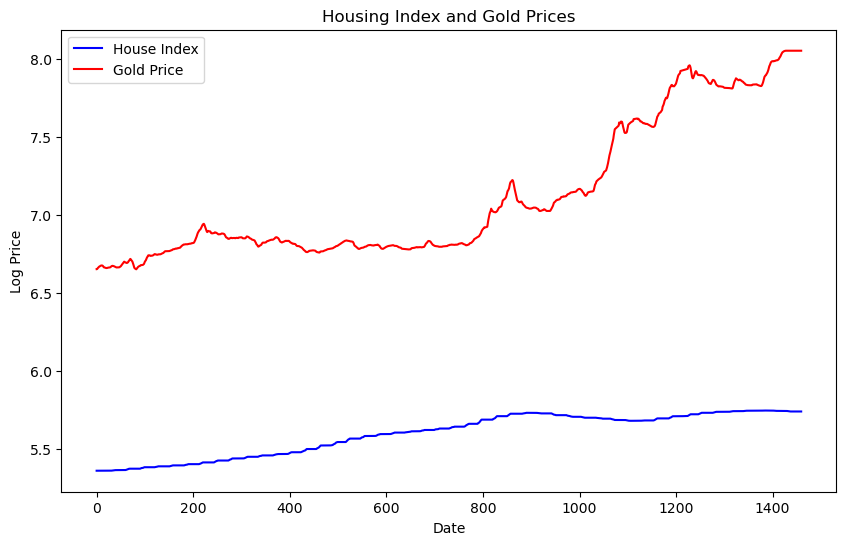

In [58]:
merged_data_list_house_gold = []

# Convert 'Date' columns to date object
housing_index['Date'] = pd.to_datetime(housing_index['Date']).dt.date
gold_prices['Timestamp'] = pd.to_datetime(gold_prices['Timestamp'], errors='coerce', utc=True)
gold_prices['Date'] = gold_prices['Timestamp'].dt.date

# Get daily gold prices
gold_daily = gold_prices.groupby('Date').last().reset_index()

for housing_index_column in housing_index.columns:
    if housing_index_column == 'Date':
        continue

    # Get start and end dates relative to each dataset
    start_date = max(housing_index['Date'].min(), gold_daily['Date'].min())
    end_date = min(housing_index['Date'].max(), gold_daily['Date'].max())

    # Filter the data based on start and end date
    housing_index_filtered = housing_index[(housing_index['Date'] >= start_date) & (housing_index['Date'] <= end_date)]
    gold_daily_filtered = gold_daily[(gold_daily['Date'] >= start_date) & (gold_daily['Date'] <= end_date)]

    # Merge the two datasets on 'Date'
    merged_data = pd.merge(housing_index_filtered, gold_daily_filtered, on='Date', how='inner')

    # Apply interpolation only to numeric columns
    numeric_cols = merged_data.select_dtypes(include=['float64', 'int64']).columns
    merged_data[numeric_cols] = merged_data[numeric_cols].interpolate(method='linear', limit_direction='both')

    # Create Log Columns
    merged_data['log_housing_index'] = np.log(merged_data[housing_index_column] + 1)
    merged_data['Log_Gold_Price'] = np.log(merged_data['24K'] + 1)

    # Calculate the mean and standard deviation for both series
    mean_gold_price = merged_data['Log_Gold_Price'].mean()
    std_gold_price = merged_data['Log_Gold_Price'].std()
    mean_stock_price = merged_data['log_housing_index'].mean()
    std_stock_price = merged_data['log_housing_index'].std()

    # Calculate thresholds for outliers
    threshold_upper_gold = mean_gold_price + 2 * std_gold_price
    threshold_lower_gold = mean_gold_price - 2 * std_gold_price
    threshold_upper_stock = mean_stock_price + 2 * std_stock_price
    threshold_lower_stock = mean_stock_price - 2 * std_stock_price

    # Remove duplicate dates
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    merged_data = merged_data.drop_duplicates(subset='Date')

    # Mask outliers
    outlier_mask_gold = (merged_data['Log_Gold_Price'] < threshold_lower_gold) | (merged_data['Log_Gold_Price'] > threshold_upper_gold)
    outlier_mask_stock = (merged_data['log_housing_index'] < threshold_lower_stock) | (merged_data['log_housing_index'] > threshold_upper_stock)

    # Set outliers to NaN
    merged_data.loc[outlier_mask_gold, 'Log_Gold_Price'] = np.nan
    merged_data.loc[outlier_mask_stock, 'log_housing_index'] = np.nan

    # Interpolate missing values for log columns
    merged_data['Log_Gold_Price'] = merged_data['Log_Gold_Price'].interpolate(method='linear')
    merged_data['log_housing_index'] = merged_data['log_housing_index'].interpolate(method='linear')

    # Apply rolling mean for smoothing
    merged_data['smoothed_log_housing_index'] = merged_data['log_housing_index'].rolling(window=7, min_periods=1).mean()
    merged_data['Smoothed_Log_Gold_Price'] = merged_data['Log_Gold_Price'].rolling(window=7, min_periods=1).mean()

    # Filter necessary columns and reindex using the date range
    filtered_data = merged_data[['Date', 'smoothed_log_housing_index', 'Smoothed_Log_Gold_Price']]
    filtered_data = filtered_data.set_index('Date').reindex(date_range).reset_index()

    # Apply interpolation only to numeric columns after reindexing
    numeric_filtered_cols = filtered_data.select_dtypes(include=['float64', 'int64']).columns
    filtered_data[numeric_filtered_cols] = filtered_data[numeric_filtered_cols].interpolate(method='linear')

    # No dropping rows, keeping NaNs as is

    merged_data_list_house_gold.append(filtered_data)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_data['smoothed_log_housing_index'], label='House Index', color='blue')
    plt.plot(filtered_data['Smoothed_Log_Gold_Price'], label='Gold Price', color='red')
    plt.title('Housing Index and Gold Prices')
    plt.xlabel('Date')
    plt.ylabel('Log Price')
    plt.legend()
    plt.show()


/Users/youssefmansour/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


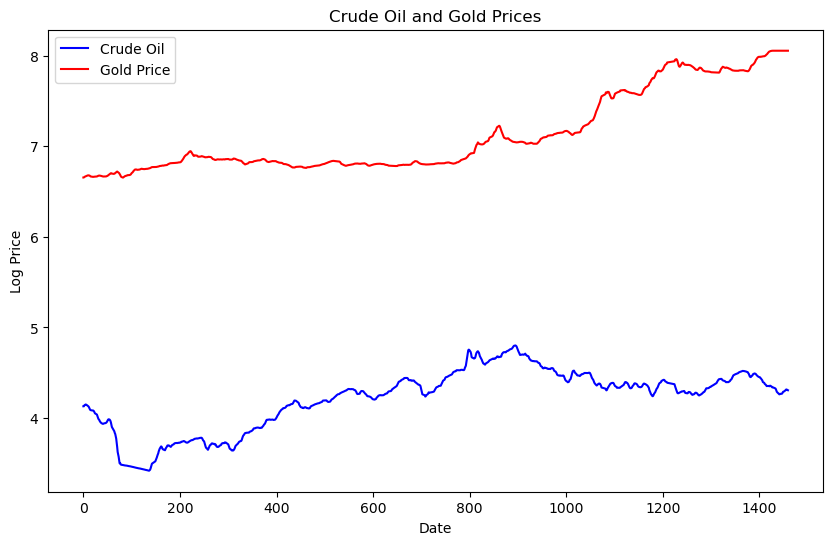

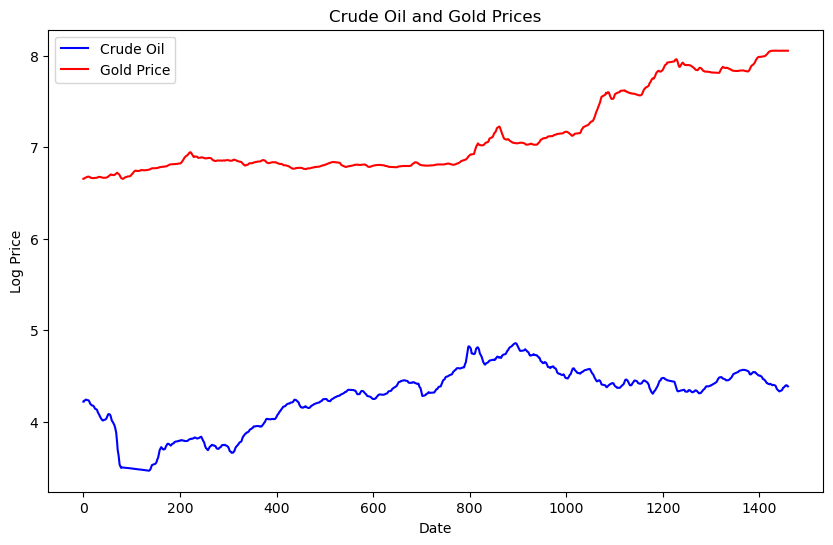

In [59]:
merged_data_list_crude_gold = []

# Convert 'Date' columns to date object
crude_oil_prices['Date'] = pd.to_datetime(crude_oil_prices['Date']).dt.date
gold_prices['Timestamp'] = pd.to_datetime(gold_prices['Timestamp'], errors='coerce', utc=True)
gold_prices['Date'] = gold_prices['Timestamp'].dt.date

# Get daily gold prices
gold_daily = gold_prices.groupby('Date').last().reset_index()

for crude_oil_prices_column in crude_oil_prices.columns:
    if crude_oil_prices_column == 'Date':
        continue

    # Get start and end dates relative to each dataset
    start_date = max(crude_oil_prices['Date'].min(), gold_daily['Date'].min())
    end_date = min(crude_oil_prices['Date'].max(), gold_daily['Date'].max())

    # Filter the data based on start and end date
    crude_oil_prices_filtered = crude_oil_prices[(crude_oil_prices['Date'] >= start_date) & (crude_oil_prices['Date'] <= end_date)]
    gold_daily_filtered = gold_daily[(gold_daily['Date'] >= start_date) & (gold_daily['Date'] <= end_date)]

    # Merge the two datasets on 'Date'
    merged_data = pd.merge(crude_oil_prices_filtered, gold_daily_filtered, on='Date', how='inner')

    # Apply interpolation only to numeric columns
    numeric_cols = merged_data.select_dtypes(include=['float64', 'int64']).columns
    merged_data[numeric_cols] = merged_data[numeric_cols].interpolate(method='linear', limit_direction='both')

    # Create Log Columns
    merged_data['log_crude_oil_prices'] = np.log(merged_data[crude_oil_prices_column] + 1)
    merged_data['Log_Gold_Price'] = np.log(merged_data['24K'] + 1)

    # Calculate the mean and standard deviation for both series
    mean_gold_price = merged_data['Log_Gold_Price'].mean()
    std_gold_price = merged_data['Log_Gold_Price'].std()
    mean_stock_price = merged_data['log_crude_oil_prices'].mean()
    std_stock_price = merged_data['log_crude_oil_prices'].std()

    # Calculate thresholds for outliers
    threshold_upper_gold = mean_gold_price + 2 * std_gold_price
    threshold_lower_gold = mean_gold_price - 2 * std_gold_price
    threshold_upper_stock = mean_stock_price + 2 * std_stock_price
    threshold_lower_stock = mean_stock_price - 2 * std_stock_price

    # Remove duplicate dates
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    merged_data = merged_data.drop_duplicates(subset='Date')

    # Mask outliers
    outlier_mask_gold = (merged_data['Log_Gold_Price'] < threshold_lower_gold) | (merged_data['Log_Gold_Price'] > threshold_upper_gold)
    outlier_mask_stock = (merged_data['log_crude_oil_prices'] < threshold_lower_stock) | (merged_data['log_crude_oil_prices'] > threshold_upper_stock)

    # Set outliers to NaN
    merged_data.loc[outlier_mask_gold, 'Log_Gold_Price'] = np.nan
    merged_data.loc[outlier_mask_stock, 'log_crude_oil_prices'] = np.nan

    # Interpolate missing values for log columns
    merged_data['Log_Gold_Price'] = merged_data['Log_Gold_Price'].interpolate(method='linear')
    merged_data['log_crude_oil_prices'] = merged_data['log_crude_oil_prices'].interpolate(method='linear')

    # Apply rolling mean for smoothing
    merged_data['smoothed_log_crude_oil_prices'] = merged_data['log_crude_oil_prices'].rolling(window=7, min_periods=1).mean()
    merged_data['Smoothed_Log_Gold_Price'] = merged_data['Log_Gold_Price'].rolling(window=7, min_periods=1).mean()

    # Filter necessary columns and reindex using the date range
    filtered_data = merged_data[['Date', 'smoothed_log_crude_oil_prices', 'Smoothed_Log_Gold_Price']]
    filtered_data = filtered_data.set_index('Date').reindex(date_range).reset_index()

    # Apply interpolation only to numeric columns after reindexing
    numeric_filtered_cols = filtered_data.select_dtypes(include=['float64', 'int64']).columns
    filtered_data[numeric_filtered_cols] = filtered_data[numeric_filtered_cols].interpolate(method='linear')

    # No dropping rows, keeping NaNs as is

    merged_data_list_crude_gold.append(filtered_data)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_data['smoothed_log_crude_oil_prices'], label='Crude Oil', color='blue')
    plt.plot(filtered_data['Smoothed_Log_Gold_Price'], label='Gold Price', color='red')
    plt.title('Crude Oil and Gold Prices')
    plt.xlabel('Date')
    plt.ylabel('Log Price')
    plt.legend()
    plt.show()

In [60]:
model_list = []
for merged_data_for_model in merged_data_list_federal_gold:
    df = merged_data_for_model[['index', 'Smoothed_Log_Gold_Price']]
    df.columns = ['ds', 'y']
    df['smoothed_log_federal_rates'] = merged_data_for_model['smoothed_log_federal_rates']
    model = Prophet()
    model.add_regressor('smoothed_log_federal_rates')
    model.fit(df)
    model_list.append(model)

    

21:43:40 - cmdstanpy - INFO - Chain [1] start processing
21:43:41 - cmdstanpy - INFO - Chain [1] done processing


In [61]:
model_list2 = []
for merged_data_for_model in merged_data_list_house_gold:
    df = merged_data_for_model[['index', 'Smoothed_Log_Gold_Price']]
    df.columns = ['ds', 'y']
    df['smoothed_log_housing_index'] = merged_data_for_model['smoothed_log_housing_index']
    model = Prophet()
    model.add_regressor('smoothed_log_housing_index')
    model.fit(df)
    model_list2.append(model)

21:43:41 - cmdstanpy - INFO - Chain [1] start processing
21:43:42 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
model_list3 = []
for merged_data_for_model in merged_data_list_crude_gold:
    df = merged_data_for_model[['index', 'Smoothed_Log_Gold_Price']]
    df.columns = ['ds', 'y']
    df['smoothed_log_crude_oil_prices'] = merged_data_for_model['smoothed_log_crude_oil_prices']
    model = Prophet()
    model.add_regressor('smoothed_log_crude_oil_prices')
    model.fit(df)
    model_list3.append(model)

21:43:42 - cmdstanpy - INFO - Chain [1] start processing
21:43:42 - cmdstanpy - INFO - Chain [1] done processing
21:43:43 - cmdstanpy - INFO - Chain [1] start processing
21:43:43 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
predictions_federal_gold = []
for i, model in enumerate(model_list):    
    future = model.make_future_dataframe(periods=290)
    last_known_federal_rates = merged_data_list_federal_gold[i]['smoothed_log_federal_rates'].iloc[-1]
    future['smoothed_log_federal_rates'] = last_known_federal_rates
    forecast = model.predict(future)
    forecast['Predicted_Gold_Price'] = np.exp(forecast['yhat'])
    forecast['Date'] = forecast['ds'].dt.date
    pred = forecast[['Date', 'Predicted_Gold_Price']]
    predictions_federal_gold.append(pred)
    
predictions_federal_gold

[            Date  Predicted_Gold_Price
 0     2020-01-01            909.467211
 1     2020-01-02            911.063281
 2     2020-01-03            912.904565
 3     2020-01-04            914.553891
 4     2020-01-05            916.278578
 ...          ...                   ...
 1745  2024-10-11           4671.605583
 1746  2024-10-12           4687.369533
 1747  2024-10-13           4704.727880
 1748  2024-10-14           4722.549692
 1749  2024-10-15           4741.271190
 
 [1750 rows x 2 columns]]

In [64]:
predictions_house_gold = []
for i, model in enumerate(model_list2):
    future = model.make_future_dataframe(periods=290)
    last_known_house_index = merged_data_list_house_gold[i]['smoothed_log_housing_index'].iloc[-1]
    future['smoothed_log_housing_index'] = last_known_house_index
    forecast = model.predict(future)
    forecast['Predicted_Gold_Price'] = np.exp(forecast['yhat'])
    forecast['Date'] = forecast['ds'].dt.date
    pred = forecast[['Date', 'Predicted_Gold_Price']]
    predictions_house_gold.append(pred)

predictions_house_gold

[            Date  Predicted_Gold_Price
 0     2020-01-01            862.948878
 1     2020-01-02            864.982412
 2     2020-01-03            867.188576
 3     2020-01-04            869.207484
 4     2020-01-05            871.370207
 ...          ...                   ...
 1745  2024-10-11           4858.850898
 1746  2024-10-12           4874.318852
 1747  2024-10-13           4891.659918
 1748  2024-10-14           4908.803691
 1749  2024-10-15           4926.675379
 
 [1750 rows x 2 columns]]

In [65]:
predictions_crude_gold = []
for i, model in enumerate(model_list3):
    future = model.make_future_dataframe(periods=290)
    last_known_crude_oil = merged_data_list_crude_gold[i]['smoothed_log_crude_oil_prices'].iloc[-1]
    future['smoothed_log_crude_oil_prices'] = last_known_crude_oil
    forecast = model.predict(future)
    forecast['Predicted_Gold_Price'] = np.exp(forecast['yhat'])
    forecast['Date'] = forecast['ds'].dt.date
    pred = forecast[['Date', 'Predicted_Gold_Price']]
    predictions_crude_gold.append(pred)

predictions_crude_gold

[            Date  Predicted_Gold_Price
 0     2020-01-01            762.542139
 1     2020-01-02            764.151823
 2     2020-01-03            765.924406
 3     2020-01-04            767.531235
 4     2020-01-05            769.231585
 ...          ...                   ...
 1745  2024-10-11           5056.261613
 1746  2024-10-12           5072.757213
 1747  2024-10-13           5090.842515
 1748  2024-10-14           5108.607893
 1749  2024-10-15           5127.320825
 
 [1750 rows x 2 columns],
             Date  Predicted_Gold_Price
 0     2020-01-01            762.992447
 1     2020-01-02            764.597535
 2     2020-01-03            766.367914
 3     2020-01-04            767.974776
 4     2020-01-05            769.677618
 ...          ...                   ...
 1745  2024-10-11           5047.437233
 1746  2024-10-12           5063.748635
 1747  2024-10-13           5081.612320
 1748  2024-10-14           5099.171145
 1749  2024-10-15           5117.670722
 
 [1750 row

In [66]:
gold_prices_target['Date'] = pd.to_datetime(gold_prices_target['date'])
gold_prices_target['Date'] = gold_prices_target['Date'].dt.date
gold_prices_target.drop(columns=['date'], inplace=True)
gold_prices_target.set_index('Date' , inplace=True)

In [67]:
crude_oil_prices.head()

,Date,WTI Oil Price FOB (Dollars per Barrel),Europe Brent Crude Oil (Dollars per Barrel)
0,2020-01-01,61.17,67.05
1,2020-01-02,61.17,67.05
2,2020-01-03,63.00,69.08
3,2020-01-04,63.00,69.08
4,2020-01-05,63.00,69.08


In [68]:
crude_oil_prices['Date'] = pd.to_datetime(crude_oil_prices['Date'])
crude_oil_prices['Date'] = crude_oil_prices['Date'].dt.date
crude_oil_prices.set_index('Date' , inplace=True)

In [69]:
features_df = pd.DataFrame(crude_oil_prices['Europe Brent Crude Oil (Dollars per Barrel)'].pct_change() * 100).shift(-1)
X = features_df[['Europe Brent Crude Oil (Dollars per Barrel)']]
X

,Europe Brent Crude Oil (Dollars per Barrel)
Date,
2020-01-01,0.000000
2020-01-02,3.027591
2020-01-03,0.000000
2020-01-04,0.000000
2020-01-05,1.693688
...,...
2023-12-26,0.922348
2023-12-27,-2.383599
2023-12-28,-1.707996


# EDA

In [70]:
gold_prices_target.describe()

,pct_change
count,1461.000000
mean,0.113309
std,1.180442
min,-6.092843
25%,-0.186986
50%,0.000000
75%,0.373715
max,14.916585


In [71]:
crude_oil_prices.describe()

,WTI Oil Price FOB (Dollars per Barrel),Europe Brent Crude Oil (Dollars per Barrel)
count,1460.000000,1460.000000
mean,69.972726,73.972760
std,22.465432,23.870567
min,-36.980000,9.120000
25%,53.325000,58.362500
50%,72.955000,76.450000
75%,83.175000,87.877500
max,123.640000,133.180000


# Feature Selection

In [72]:
features_df = pd.merge(gold_prices_target, (crude_oil_prices['Europe Brent Crude Oil (Dollars per Barrel)'].pct_change() * 100).shift(-1), on='Date', how='left')
features_df.fillna(0, inplace=True)
features_df

,pct_change,Europe Brent Crude Oil (Dollars per Barrel)
Date,,
2020-01-01,0.129032,0.000000
2020-01-02,1.288660,3.027591
2020-01-03,0.636132,0.000000
2020-01-04,0.126422,0.000000
2020-01-05,1.262626,1.693688
...,...,...
2023-12-27,-4.334869,-2.383599
2023-12-28,1.302747,-1.707996
2023-12-29,1.593514,0.000000


# Modelling

In [73]:
X = features_df[['Europe Brent Crude Oil (Dollars per Barrel)']]  
y = features_df['pct_change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [74]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Validation

In [75]:
start_time = time.time()
y_pred = model.predict(X_test)
end_time = time.time()
inference_time = end_time - start_time

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mda = np.mean(np.sign(np.diff(y_test)) == np.sign(np.diff(y_pred)))

y_test_buckets = pd.qcut(y_test, 4, labels=False) 
y_pred_buckets = pd.qcut(y_pred, 4, labels=False)

f1 = f1_score(y_test_buckets, y_pred_buckets, average='weighted')

print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Directional Accuracy: {mda}')
print(f'Bucketized F1 Score: {f1}')
print(f'Inference Time (seconds): {inference_time}')


Root Mean Squared Error: 1.3640185276741963
Mean Directional Accuracy: 0.4143835616438356
Bucketized F1 Score: 0.3685853949374926
Inference Time (seconds): 0.0007290840148925781


## Visualize the results

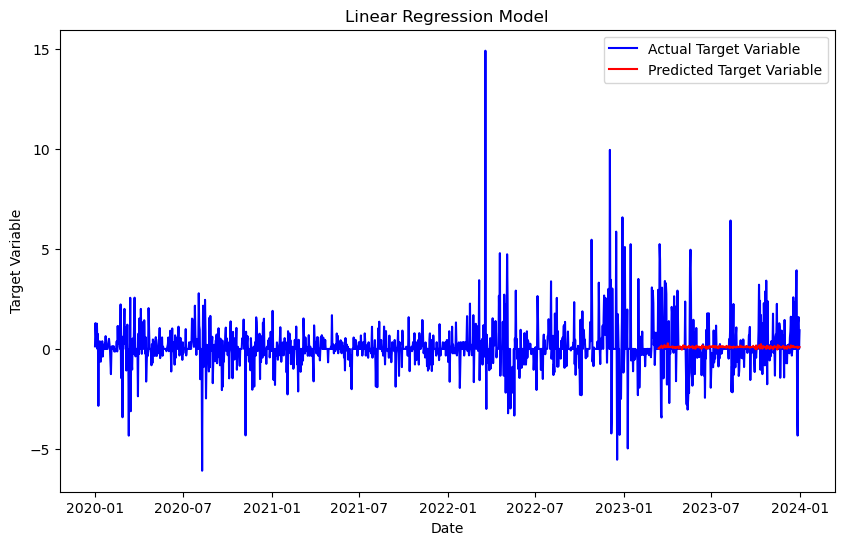

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(features_df.index, y, label='Actual Target Variable', color='blue')
plt.plot(X_test.index, y_pred, label='Predicted Target Variable', color='red')
plt.title('Linear Regression Model')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

# Saving Model

In [77]:
with open('../Pickles/linear_regression_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Loading Model

In [78]:
with open('../Pickles/linear_regression_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

y_pred = loaded_model.predict(X_test)
output_df = pd.DataFrame({
    'date': X_test.index,
    'prediction': y_pred.flatten()
})
output_df

,date,prediction
0,2023-03-14,0.022360
1,2023-03-15,0.058431
2,2023-03-16,0.030310
3,2023-03-17,0.093593
4,2023-03-18,0.093593
...,...,...
288,2023-12-27,0.040820
289,2023-12-28,0.055778
290,2023-12-29,0.093593
291,2023-12-30,0.093593
